#데이터 로드 

In [ ]:
!mkdir Data 
%cd ./Data 
!gdown https://drive.google.com/u/0/uc?id=1SZ5j8SJTCqQQuNHTMDHXSOMShKUvB479&export=download
!unzip open.zip 
!rm -f open.zip
%cd /content

In [1]:
import os 
import warnings 
warnings.filterwarnings('ignore')

import cv2 
import pandas as pd 
from glob import glob 
from tqdm import tqdm 
import random 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras import applications 
from PIL import Image
from tensorflow.keras.utils import Sequence
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback
import math 
import torchvision.transforms as transforms 
#Random Seed 고정 
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
seed_everything()     

# 데이터 전처리 

In [2]:
#데이터 폴더에서 df csv만 읽어온 뒤 img_dirs과 labels 정제 함 
def df_init(data_dir):
    df = pd.read_csv(os.path.join(data_dir,'train.csv'))    
    img_dirs = df['img_path'].values
    labels = df['artist'].values
    return img_dirs, labels 

# 라벨 데이터 전처리 용 함수 
def label_init(labels):
    label_unique = np.unique(labels)
    label_decoder = {key:value for key,value in enumerate(label_unique)}
    label_encoder = {value:key for key,value in enumerate(label_unique)}
    return label_encoder, label_decoder 

# Train-valid split용 전처리 함수 
def train_valid_split(img_dirs,labels,ratio):
    valid_index = int(len(img_dirs)*ratio)
    train_x = img_dirs[:valid_index]
    valid_x = img_dirs[valid_index:]

    train_y = labels[:valid_index]
    valid_y = labels[valid_index:]
    return [train_x, train_y],[valid_x,valid_y]

#위 전처리 함수 들을 한번에 처리하는 함수 
#label encoder는 이후 사용을 하지 않지만 decoder는 inference에서 사용하기 때문에 return을 해 줌     
def data_preprocess(data_dir):
    #데이터 로드 
    img_dirs,labels = df_init(data_dir)
    #라벨 데이터 정제 
    label_encoder,label_decoder = label_init(labels)
    labels = pd.Series(labels).apply(lambda x : label_encoder[x]).values
    
    #Train - valid split 
    valid_ratio = 0.8 
    [train_x, train_y],[valid_x,valid_y] = train_valid_split(img_dirs,labels,valid_ratio)
    return [train_x, train_y],[valid_x,valid_y],label_decoder 

In [74]:
class DataGenerator(Sequence):
  def __init__(self,img_dirs,labels,data_dir,img_size=256,batch_size=16,shuffle=False,augmentation=False):
    self.img_dirs = img_dirs 
    self.labels = labels 
    self.img_size = img_size 
    self.batch_size = batch_size 
    self.data_dir = data_dir
    self.shuffle = shuffle 
    self.augmentation = self.augment_init(augmentation)

  def __len__(self):
    return math.ceil(len(self.img_dirs)/self.batch_size)
  
  def on_epoch_end(self):
    '''
    에폭 끝날 때 마다 random shuffle을 해 줌 
    '''
    if self.shuffle == True:
      indexes = np.arange(len(self.img_dirs))
      np.random.shuffle(indexes)
      self.img_dirs = self.img_dirs[indexes]
      self.labels = self.labels[indexes]
    else:
      pass 
    
  def augment_init(self,augmentation):
    '''
    default Augmentation : RandomCrop, Resize
    리사이즈 하고자 하는 사이즈 보다 1.5배 크게 자른 뒤 리사이즈 함 
    '''
    if augmentation == False:
      augment = transforms.Compose([
                                    transforms.RandomCrop(self.img_size*1.5),
                                    transforms.Resize(self.img_size)
                                  ])
      return augment 
    else:
      return augmentation 
    
  def img_preprocess(self,img):
    '''
    이미지 전처리하는 내부 함수 
    '''
    img = np.array(self.augmentation(img))
    img = img/255.
    img = img.astype(np.float32)
    return img 

  def img_load(self,img_dir):
    '''
    이미지 디렉토리로 이미지 한개씩 읽어오는 내부 함수 
    '''
    img = Image.open(os.path.join(self.data_dir,img_dir))
    img = self.img_preprocess(img)
    return img 

  def __getitem__(self,index):
    '''
    배치 단위로 이미지 읽어오고, 라벨 배치 사이즈만큼 자르고 출력하는 함수 
    '''
    self.batch_dirs = self.img_dirs[index*self.batch_size:(index+1)*self.batch_size]
    self.batch_labels = self.labels[index*self.batch_size:(index+1)*self.batch_size]

    self.batch_imgs = [self.img_load(img_dir) for img_dir in self.batch_dirs]
    return np.array(self.batch_imgs),np.array(self.batch_labels)

# 모델 구축 

In [4]:
# model도 하나의 객체이기 때문에 메소드로 만든 뒤 return 하게 할 수 있음 
def model_init(cfg):
    global label_unique #softmax output 갯수 설정 용
    res50 = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(cfg['img_size'], cfg['img_size'],3)) #size -> 256, 256 
    res50.trainable = True

    img_input = layers.Input(shape = (cfg['img_size'],cfg['img_size'],3))
    x = res50(img_input)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512,activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256,activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(len(label_unique),activation='softmax')(x)
    model = keras.Model(img_input,out)
    return model 

In [5]:
#콜백 

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):
    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show()
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

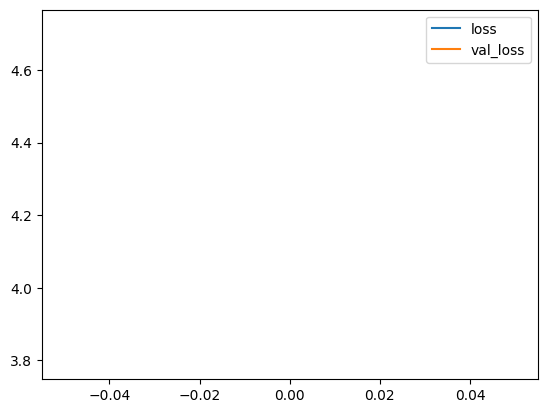

loss =  3.7938179969787598 , val_loss =  4.72045373916626
296/296 [==============================] - 67s 206ms/step - loss: 3.7938 - accuracy: 0.1110 - val_loss: 4.7205 - val_accuracy: 0.1023
Epoch 2/50
296/296 [==============================] - ETA: 0s - loss: 3.5433 - accuracy: 0.1390

KeyboardInterrupt: 

In [6]:
# 하이퍼 파라미터 조정 
cfg ={}
cfg['epochs'] = 50 
cfg['lr'] = 1e-3 
cfg['batch_size'] = 16 
cfg['seed'] = 42 
cfg['img_size'] = 256 
cfg['data_dir'] = './Data'
    

#데이터 전처리 및 로더 부문 
[train_x, train_y],[valid_x,valid_y],label_decoder  = data_preprocess(cfg['data_dir'])
train_loader = DataGenerator(train_x,train_y,cfg['data_dir'],cfg['img_size'],cfg['batch_size'])
valid_loader = DataGenerator(valid_x,valid_y,cfg['data_dir'],cfg['img_size'],cfg['batch_size'])
label_unique = np.unique(train_loader.labels) #model softmax output 갯수 설정 용 


model = model_init(cfg)
#call backs 선언
plot_losses = PlotLosses()

#모델 학습 용 객체들 선언 
optimizer = tf.optimizers.Adam(learning_rate = cfg['lr'])
loss_fn = 'sparse_categorical_crossentropy'
model.compile(optimizer=optimizer,loss = loss_fn,metrics=['accuracy'])
#제너레이터를 사용하는 경우 x,y 따로 설정 하지 않고 batch_size도 따로 설정하지 않음
#제너레이터 안에 모두 있기 때문에 model.fit 안에 넣어주면 자동으로 해줌 
model.fit(train_loader,
          validation_data = valid_loader,
          epochs = cfg['epochs'],
          verbose = 1,
          callbacks = [plot_losses],
          )
#학습한 모델 저장 
model.save('model.h5')

# Inference 

In [2]:
# 저장한 모델 로드 
model = tf.keras.models.load_model('model.h5')

In [8]:
#테스트 데이터용 제너레이터 
from tensorflow.keras.utils import Sequence
import math 
class Test_Generator(Sequence):
  def __init__(self,img_dirs,img_size=256,batch_size=8):
    self.img_dirs = img_dirs 
    self.img_size = img_size 
    self.batch_size = batch_size 

  def __len__(self):
    return math.ceil(len(self.img_dirs)/self.batch_size)
  
  def img_preprocess(self,img):
    img = cv2.resize(img,dsize=(self.img_size,self.img_size))
    img = img/255.
    img = img.astype(np.float16)
    return img 

  def img_load(self,img_dir):
    img = cv2.imread(img_dir)
    img = self.img_preprocess(img)
    return img 

  def __getitem__(self,index):
    self.batch_dirs = self.img_dirs[index*self.batch_size:(index+1)*self.batch_size]

    temp_imgs = [self.img_load(img_dir) for img_dir in self.batch_dirs]
    return np.array(temp_imgs)

In [23]:
test_dirs = sorted(glob('./Data/test/*.jpg'))
test_data = Test_Generator(test_dirs)

In [31]:
y_ = model.predict(x=test_data)
predicted = np.argmax(y_,axis=1)
predicted_label = pd.Series(predicted).apply(lambda x : label_decoder[x]).values

In [34]:
submission = pd.read_csv('./Data/sample_submission.csv')
submission['artist'] = predicted_label
submission.to_csv('submission.csv',index=False)

# 결과 

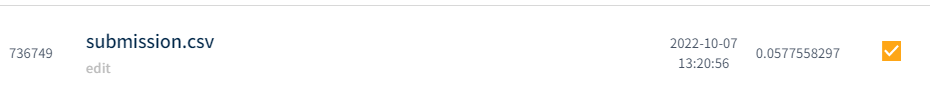